In [1]:
import os

test_dataset = '/content/Acne-21/test'
val_dataset = '/content/Acne-21/valid'
train_dataset = '/content/Acne-21/train'

!pip install roboflow
from dotenv import load_dotenv
from roboflow import Roboflow
load_dotenv()
rf = Roboflow(api_key=os.getenv("ROBOFLOW_API_KEY"))
project = rf.workspace("kritsakorn").project("acne-kbm0q")
version = project.version(21)
dataset = version.download("voc")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 70.2/70.2 kB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.3/158.3 kB 6.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.7/178.7 kB 8.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 5.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.1/49.1 MB 18.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.7/86.7 kB 12.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 7.6 MB/s eta 0:00:00
  Attempting uninstall: opencv-python-headless
    Found existing installation: opencv-python-headless 4.9.0.80
    Uninstalling opencv-python-headless-4.9.0.80:
      Successfully uninstalled opencv-python-headless-4.9.0.80
  Attempting uninstall: idna
    Found existing installation: idna 3.6
    Uninstalling idna-3.6:
      Successfully uninstalled idna-3.6
  Attempting uninstall: cycler
    Found existing installation: cycler 

loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to Acne-21 in voc:: 100%|██████████| 2515/2515 [00:00<00:00, 8787.79it/s]


In [15]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from transformers import Dinov2Model, Dinov2Config
'''
class DinoSegmentationModel(nn.Module):
    def __init__(self, num_classes):
        super(DinoSegmentationModel, self).__init__()
        # Load the DinoV2 pre-trained model as the backbone
        self.backbone = torch.hub.load('facebookresearch/dinov2', 'dinov2_vits14')

        # Replace the classification head with a segmentation head
        self.segmentation_head = nn.Sequential(
            # A convolutional layer that upscales the feature map to the input size
            nn.ConvTranspose2d(in_channels=8, out_channels=252, kernel_size=2, stride=2),

            # nn.BatchNorm2d(252),
            nn.ReLU(inplace=True),
            # Further layers can be added here as needed
            # The final layer should have 'num_classes' outputs for pixel-wise classification
            nn.Conv2d(in_channels=252, out_channels=num_classes, kernel_size=1)
        )

    def forward(self, x):
        # Pass the input through the backbone to get the feature map
        features = self.backbone.get_intermediate_layers(x, n=1)[0]  # You'll need to adapt this call to your backbone
        if features.dim() == 3:
          features = features.unsqueeze(0)
        features = self.backbone.norm(features)  # You may need to adapt normalization for segmentation
        # Ensure features have a batch dimension as well
        features = F.interpolate(features, size=x.size()[:-2], mode='bilinear', align_corners=False)
        # Upsample and process the feature map through the segmentation head
        seg_map = self.segmentation_head(features)
        print(seg_map.shape)
        print(x.size())

        return seg_map
'''
import torch
import torch.nn as nn
import torch.nn.functional as F

#For normalization in train
class MyLayerNorm(nn.Module):
    def __init__(self, normalized_shape):
        super(MyLayerNorm, self).__init__()
        self.norm = nn.LayerNorm(normalized_shape, eps=1e-6)

    def forward(self, x):
        # x is expected to be 4D with shape [batch_size, channels, height, width]
        # B, C, H, W = x.shape
        # Flatten the spatial dimensions, apply LayerNorm, and then restore the original shape
        # x = x.permute(0, 2, 3, 1).contiguous().view(B, H * W, C)
        x = self.norm(x)
        # x = x.view(B, H, W, C).permute(0, 3, 1, 2).contiguous()
        return x


class DinoSegmentationModel(nn.Module):
    def __init__(self, num_classes):
        super(DinoSegmentationModel, self).__init__()
        self.backbone = torch.hub.load('facebookresearch/dinov2', 'dinov2_vits14')
        self.num_classes = num_classes

        # Assuming your backbone outputs a feature map of size [batch_size, 384, 14, 14] for an input of 224x224
        # Adjust the in_channels to match your backbone's output feature dimension
        self.segmentation_head = nn.Sequential(
            # Upscale to a predefined size before final classification
            nn.ConvTranspose2d(in_channels=384, out_channels=256, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=256, out_channels=num_classes, kernel_size=1)
        )
        self.custom_norm = MyLayerNorm(normalized_shape=(384, 16, 16))

        # Adapt to your specific input size
        # self.resize_to_input = nn.Upsample(size=(12, 32), mode='bilinear', align_corners=False)

    def forward(self, x):
      features = self.backbone.get_intermediate_layers(x, n=1,reshape=True)[0]
      # features = self.backbone.norm(features)
      features = self.custom_norm(features)
      # print("Features shape:", features.shape)
      seg_map = self.segmentation_head(features)
      # print("Segmentation map shape:", seg_map.shape)
      features_upsampled = F.interpolate(seg_map, size=(224,224), mode='bilinear', align_corners=False) # Be careful, this might introduce artifacts/be lossy
      # print("Features upsampled shape:", features_upsampled.shape)

      return features_upsampled

# Adjust your dataset transformations
from torchvision import transforms

class_dict = {
    'background':0,
    'dark spot':1,
    'blackheads':2,
    'whiteheads':3,
    'nodules':4,
    'pustules':5,
    'papules':6,
}
model = DinoSegmentationModel(num_classes=len(class_dict))


Using cache found in /root/.cache/torch/hub/facebookresearch_dinov2_main


In [2]:
import os
import torch
from PIL import Image
from torchvision import transforms
from torchvision.transforms import functional as TF
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import xml.etree.ElementTree as ET
import numpy as np
from tqdm import tqdm

class SegmentationDataset(Dataset):
    def __init__(self, root_dir, class_dict, image_transform=None, mask_transform=None):
        """
        Args:
            root_dir (string): Directory with all the images and XML files.
            transform (callable, optional): Optional transform to be applied on a sample.
        """
        if (image_transform == None):
          image_transform = transforms.Compose([
                transforms.Resize(256),
                transforms.CenterCrop(224),
                transforms.ToTensor(),
          ])

        if(mask_transform == None):
          mask_transform = transforms.Compose([
              transforms.Resize(256, interpolation=Image.NEAREST),
              transforms.CenterCrop(224),
          ])

        self.root_dir = root_dir
        self.image_transform = image_transform
        self.mask_transform = mask_transform
        self.class_dict = class_dict
        self.image_paths = [os.path.join(root_dir, x) for x in os.listdir(root_dir) if x.endswith('.jpg') and os.path.exists(os.path.join(root_dir, x.replace('.jpg', '.xml')))]
    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        xml_path = img_path.replace('.jpg', '.xml')
        image = Image.open(img_path).convert('RGB')
        mask = self._load_mask_from_xml(xml_path, image.size)

        image = self.image_transform(image)
        # mask = self.transform(mask)
        # mask = TF.resize(mask, (224, 224), interpolation=Image.NEAREST)  # Resize the mask with nearest neighbor
        mask = self.mask_transform(mask)
        # mask = np.array(mask).squeeze()
        # unq = np.unique(mask)
        mask = np.array(mask, dtype=np.uint8)
        mask = torch.from_numpy(mask).long()  # Convert to LongTensor for cross-entropy





        return image, mask


    def _load_mask_from_xml(self, xml_path, img_shape):
      class_dict=self.class_dict
      tree = ET.parse(xml_path)
      root = tree.getroot()
      # print(xml_path)

      # Initialize a mask with zeros (background)
      mask = np.zeros((img_shape[1], img_shape[0]), dtype=np.uint8)  # Note the shape order

      # Iterate over each object in the XML
      for obj in root.findall('object'):
          class_name = obj.find('name').text
          class_id = class_dict[class_name]

          # Extract bounding box coordinates
          bndbox = obj.find('bndbox')
          xmin = int(bndbox.find('xmin').text)
          xmax = int(bndbox.find('xmax').text)
          ymin = int(bndbox.find('ymin').text)
          ymax = int(bndbox.find('ymax').text)

          # Assign class_id to pixels within the bounding box
          mask[ymin:ymax, xmin:xmax] = class_id
          mask = mask.astype(np.uint8)


      # Convert mask to a PIL image
      return Image.fromarray(mask)



# Instantiate the datasets
train_dataset = SegmentationDataset(root_dir='/content/Acne-21/train', class_dict=class_dict)
val_dataset = SegmentationDataset(root_dir='/content/Acne-21/valid', class_dict=class_dict)
test_dataset = SegmentationDataset(root_dir='/content/Acne-21/test', class_dict=class_dict)

# Create the dataloaders
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

i = 0
for inputs, mask in tqdm(train_loader):
  # if i == 96:
  #   print(train_dataset.image_paths[i])
  #   print(np.unique(mask))
  # i+=1
  pass



dataloaders = {'train': train_loader, 'val': val_loader, 'test':test_loader}


100%|██████████| 121/121 [00:04<00:00, 29.59it/s]


/content/Acne-21/train/levle0_527_jpg.rf.29c25678bb74593523c68a85d57338f1.jpg


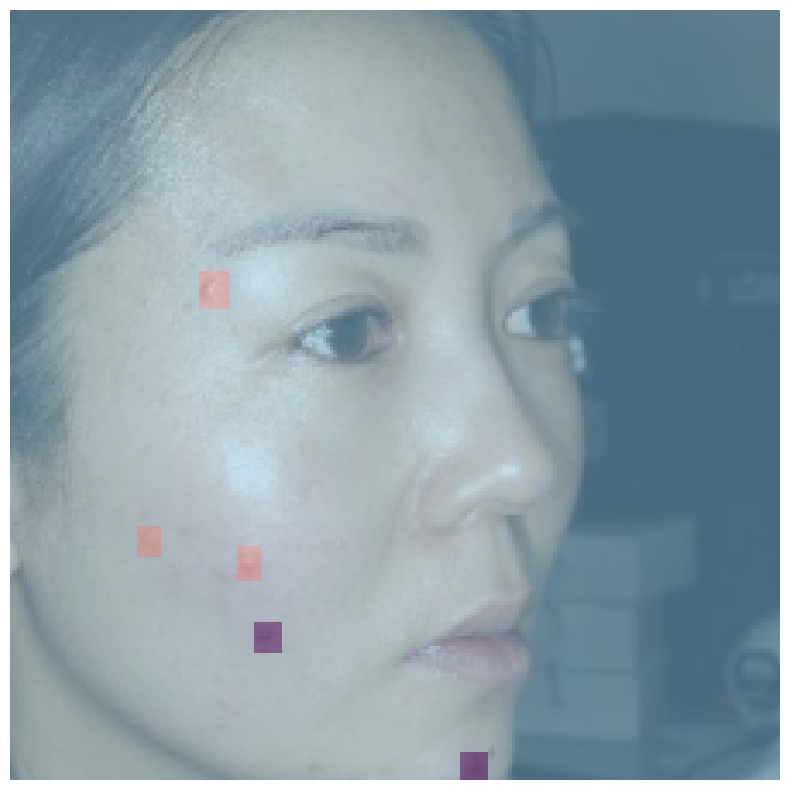

In [6]:
import torch
import numpy as np
import matplotlib.pyplot as plt

# map every class to a random color
id2label = {
    0: 'background',
    1: 'dark spot',
    2: 'blackheads',
    3: 'whiteheads',
    4: 'nodules',
    5: 'pustules',
    6: 'papules',
}


id2color = {k: list(np.random.choice(range(256), size=3)) for k, v in id2label.items()}

# Assuming 'train_dataset' is defined and has a method 'image_paths' and __getitem__
image_n = 100
image, mask = train_dataset[image_n]
print(train_dataset.image_paths[image_n])

def visualize_map(image, segmentation_map):
    # Assuming the segmentation map is a 4D tensor [batch_size, 1, height, width]
    segmentation_map = segmentation_map.squeeze()  # Remove the channel dimension
    if image.shape[0] == 3:  # assuming 3 channels
        image = image.permute(1, 2, 0)  # Convert from CHW to HWC
        image = (image * 255).type(torch.uint8).numpy()  # Convert to numpy array

    # Prepare the color overlay
    color_seg = np.zeros((segmentation_map.shape[0], segmentation_map.shape[1], 3), dtype=np.uint8)
    for label, color in id2color.items():
        color_seg[segmentation_map == label] = color

    # Combine the image with the color overlay
    alpha = 0.5  # Transparency for the overlay
    img = (1 - alpha) * image + alpha * color_seg
    img = img.astype(np.uint8)

    # Show image + mask
    plt.figure(figsize=(15, 10))
    plt.imshow(img)
    plt.axis('off')
    plt.show()
visualize_map(image, mask)

In [16]:
import torch
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from PIL import Image
import copy
from tqdm import tqdm


import matplotlib.pyplot as plt

def train_model(model, dataloaders, criterion, optimizer, scheduler, num_epochs=10):
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    best_loss = float('inf')
    device = torch.device('cuda' if torch.cuda.is_available() else "cpu")
    model.to(device)

    train_loss_history = []
    val_loss_history = []
    val_acc_history = []
    val_iou_history = []

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0
            iou_scores = []  # List to store IoU scores for each batch

            for inputs, masks in tqdm(dataloaders[phase]):
                inputs = inputs.to(device)
                masks = masks.to(device).long()

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    loss = criterion(outputs, masks)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                preds = torch.argmax(outputs, 1)
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == masks.data)

                # Calculate IoU score
                intersection = torch.logical_and(masks.data, preds)
                union = torch.logical_or(masks.data, preds)
                iou_score = torch.sum(intersection) / (torch.sum(union) + 1e-6)
                iou_scores.append(iou_score.item())

            epoch_loss = running_loss / (len(dataloaders[phase].dataset)+1e-6)
            epoch_acc = running_corrects.double() / (len(dataloaders[phase].dataset) * masks.size(1) * masks.size(2) + 1e-6)
            epoch_iou = sum(iou_scores) / (len(iou_scores)+1e-6)

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f} IoU: {epoch_iou:.4f}')

            if phase == 'train':
                train_loss_history.append(epoch_loss)
                scheduler.step()
            else:
                val_loss_history.append(epoch_loss)
                val_acc_history.append(epoch_acc.item())
                val_iou_history.append(epoch_iou)

                if epoch_loss < best_loss and epoch_acc > best_acc:
                    best_loss = epoch_loss
                    best_acc = epoch_acc
                    best_model_wts = copy.deepcopy(model.state_dict())

        print()

    print(f'Best val Loss: {best_loss:.4f} Acc: {best_acc:.4f}')

    # Load best model weights
    model.load_state_dict(best_model_wts)

    # Plot the training and validation loss
    plt.figure(figsize=(14, 5))
    plt.subplot(1, 3, 1)
    plt.plot(range(num_epochs), train_loss_history, label='Training Loss')
    plt.plot(range(num_epochs), val_loss_history, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    print("plot 1 complete")
    # Plot the validation accuracy
    plt.subplot(1, 3, 2)
    plt.plot(range(num_epochs), val_acc_history, label='Validation Accuracy (Pixelwise)')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Validation Accuracy')
    plt.legend()
    # Plot the validation IoU
    plt.subplot(1, 3, 3)
    plt.plot(range(num_epochs), val_iou_history, label='Validation IoU')
    plt.xlabel('Epochs')
    plt.ylabel('IoU')
    plt.title('Validation IoU')
    plt.legend()

    iou_disclaimer = "Note: IoU calculated per batch, not averaged over dataset."
    plt.text(0.5, -0.2, iou_disclaimer, ha='center', va='center', fontsize=8, color='red',
            transform=plt.subplot(1, 3, 3).transAxes)  # Position text relative to the IoU subplot


    plt.tight_layout()
    plt.show()

    return model




criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

# Train the model
model = train_model(model, dataloaders, criterion, optimizer, scheduler, num_epochs=5)



Epoch 0/4
----------


 22%|██▏       | 27/121 [00:04<00:14,  6.38it/s]


KeyboardInterrupt: 

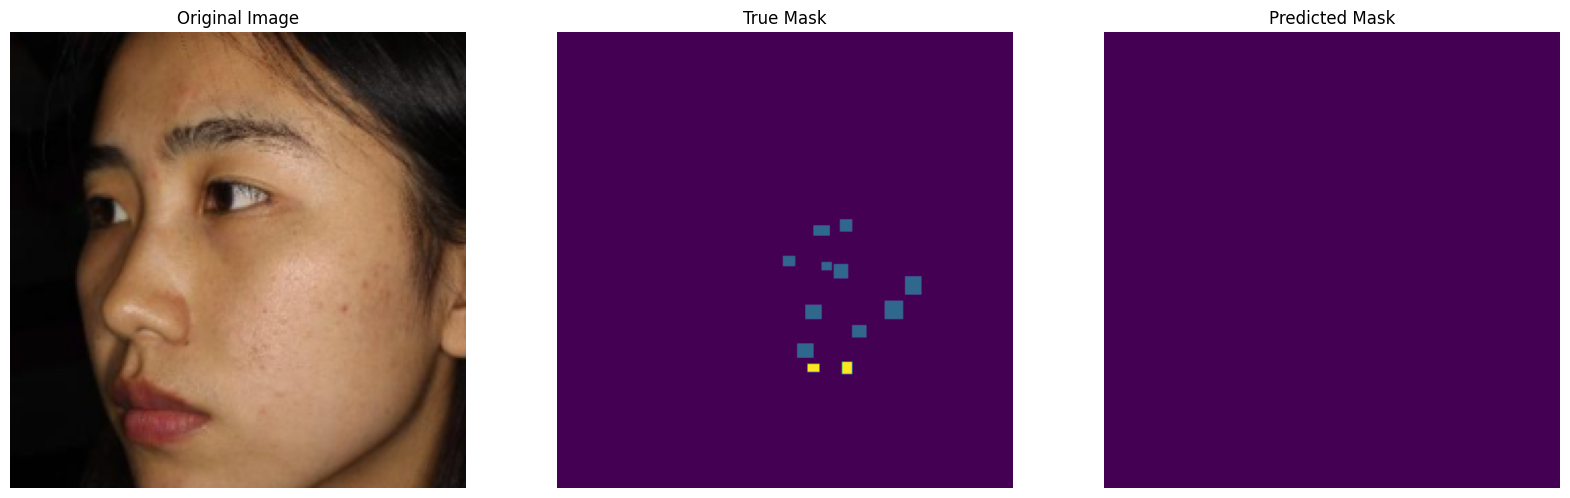

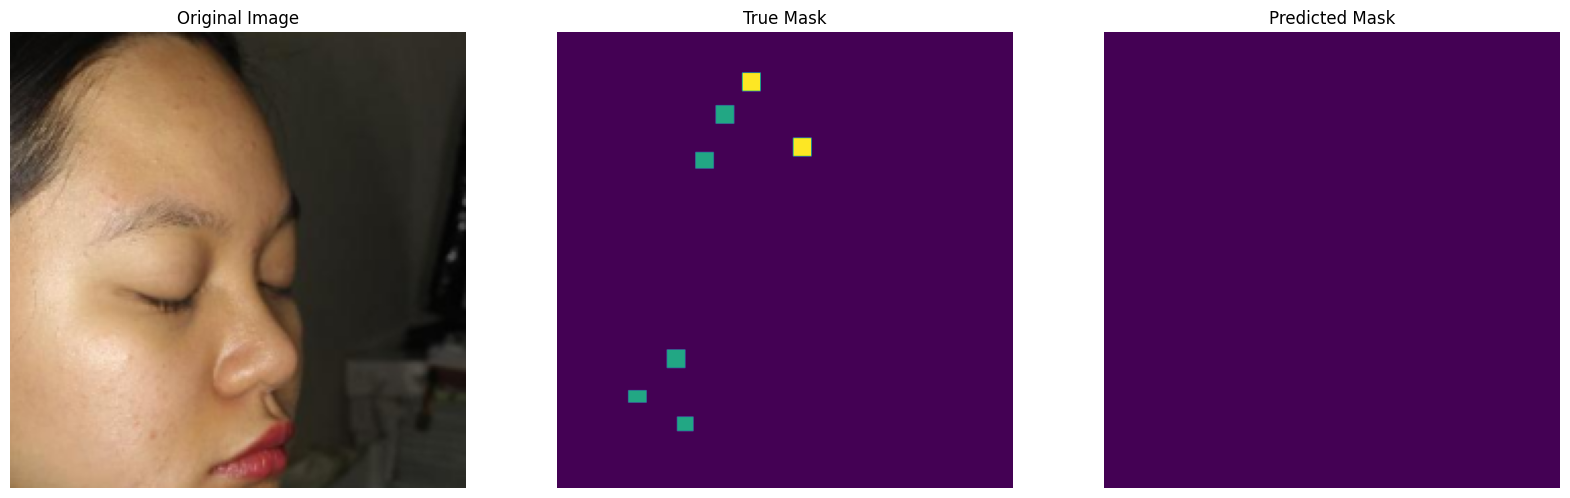

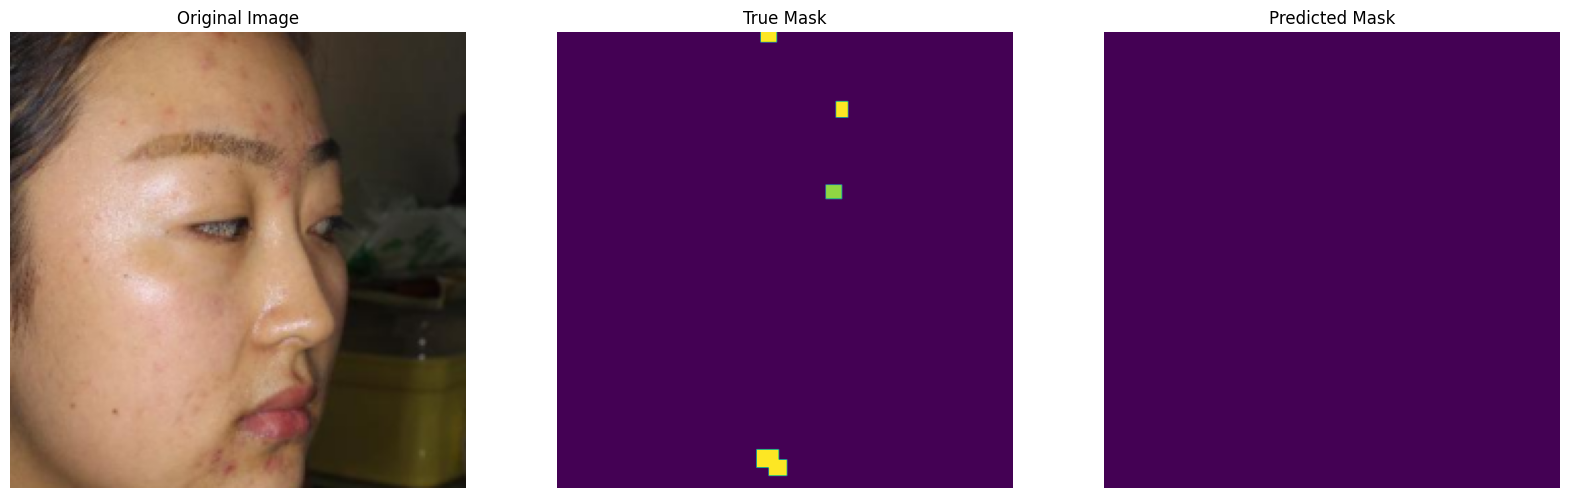

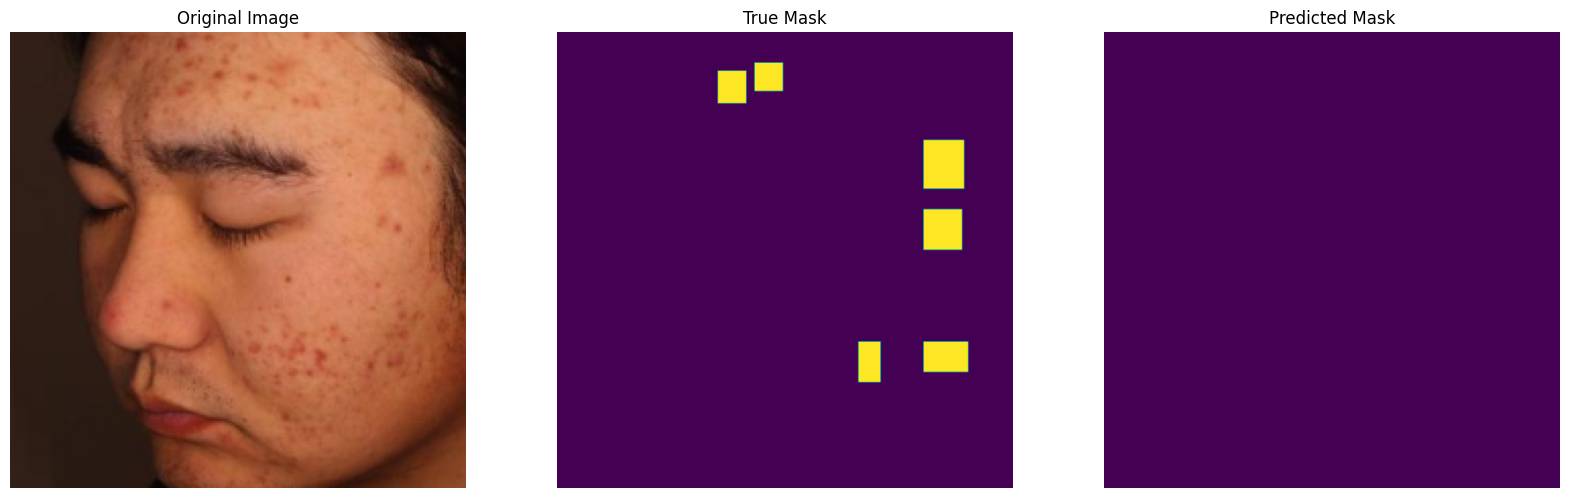

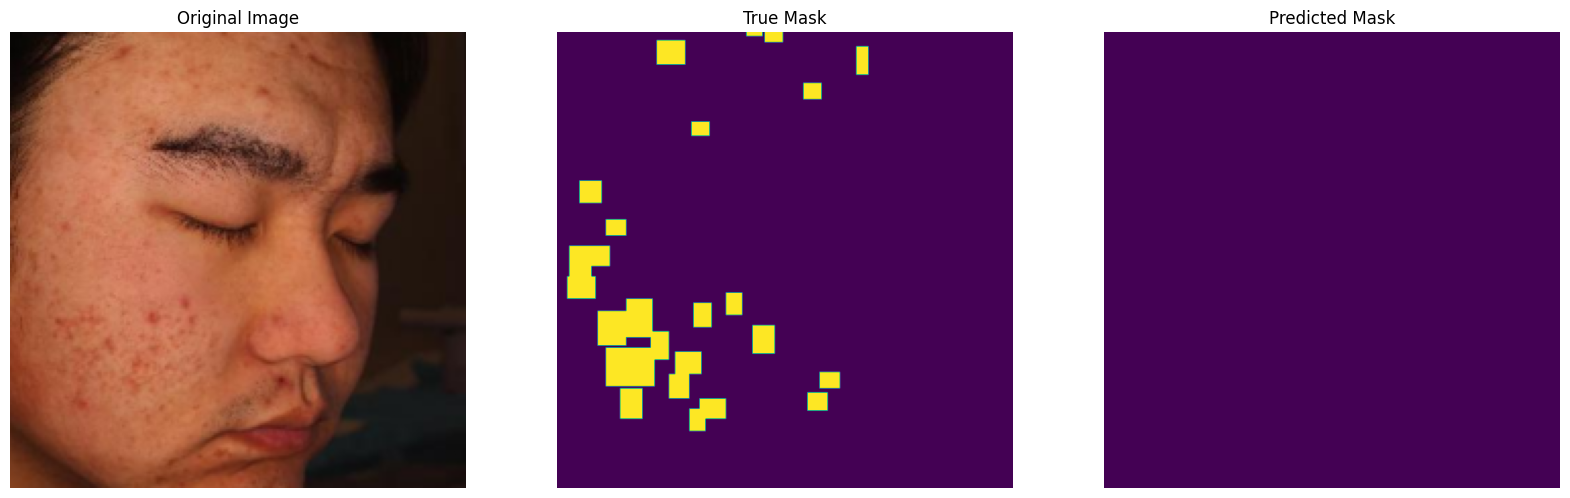

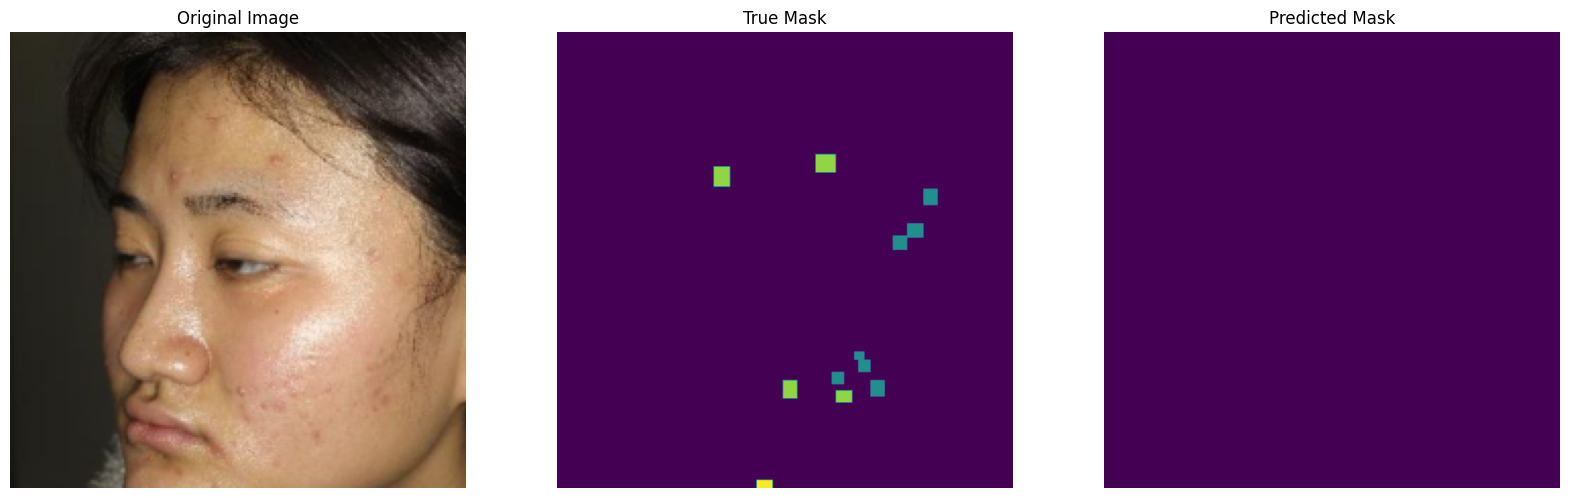

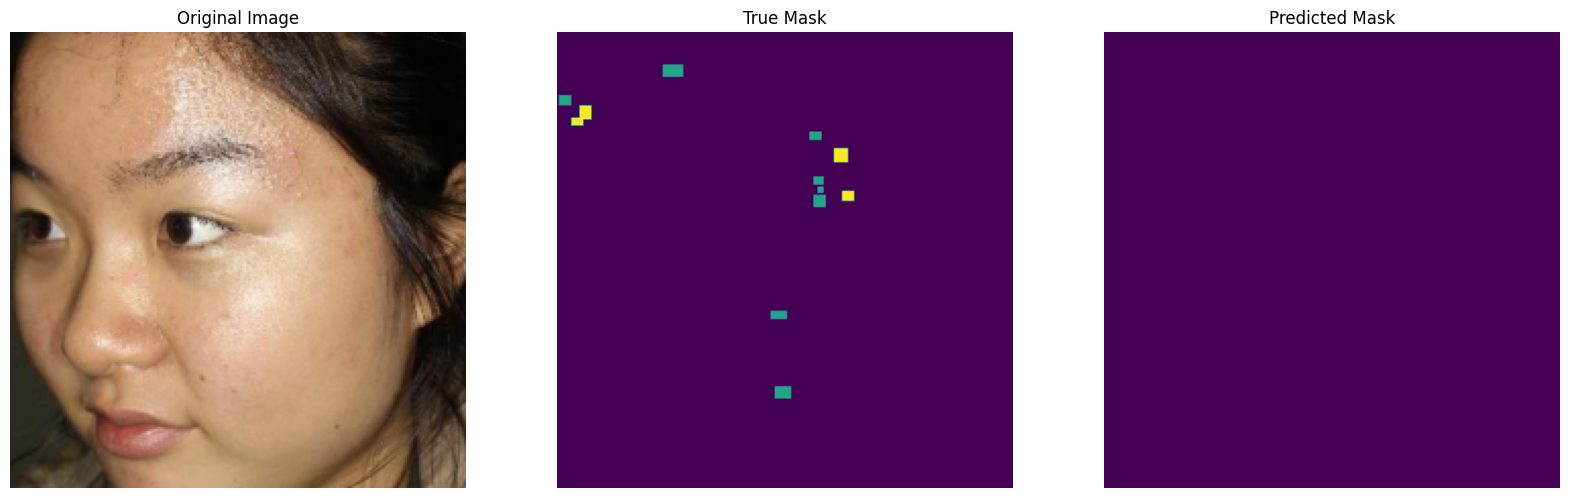

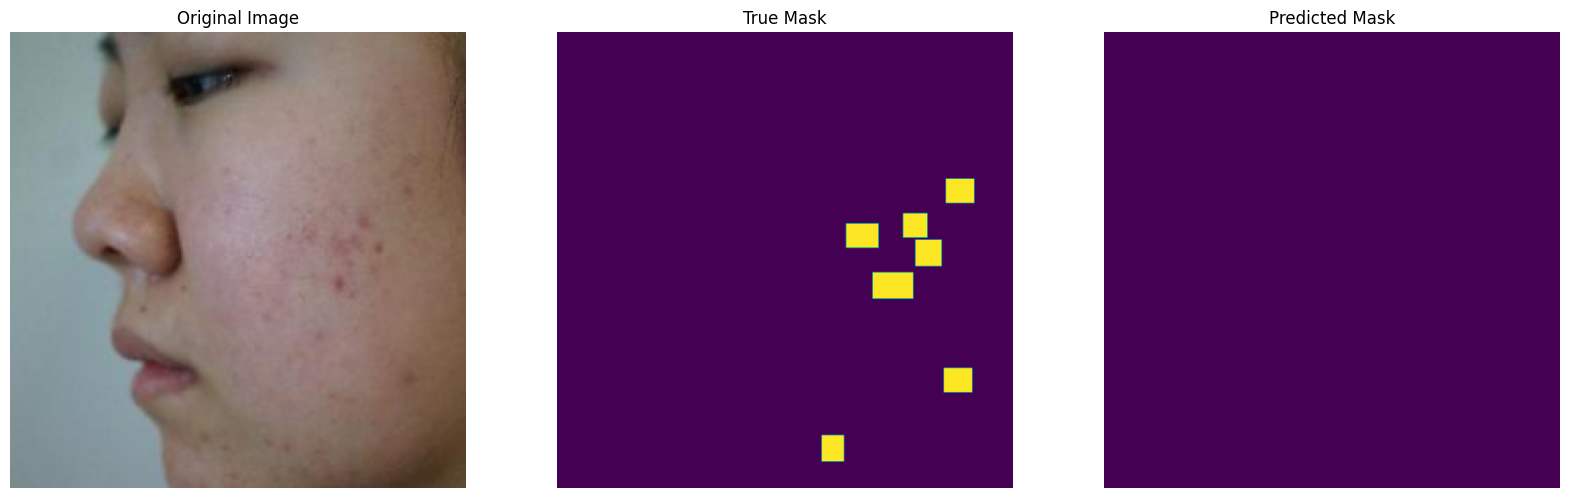

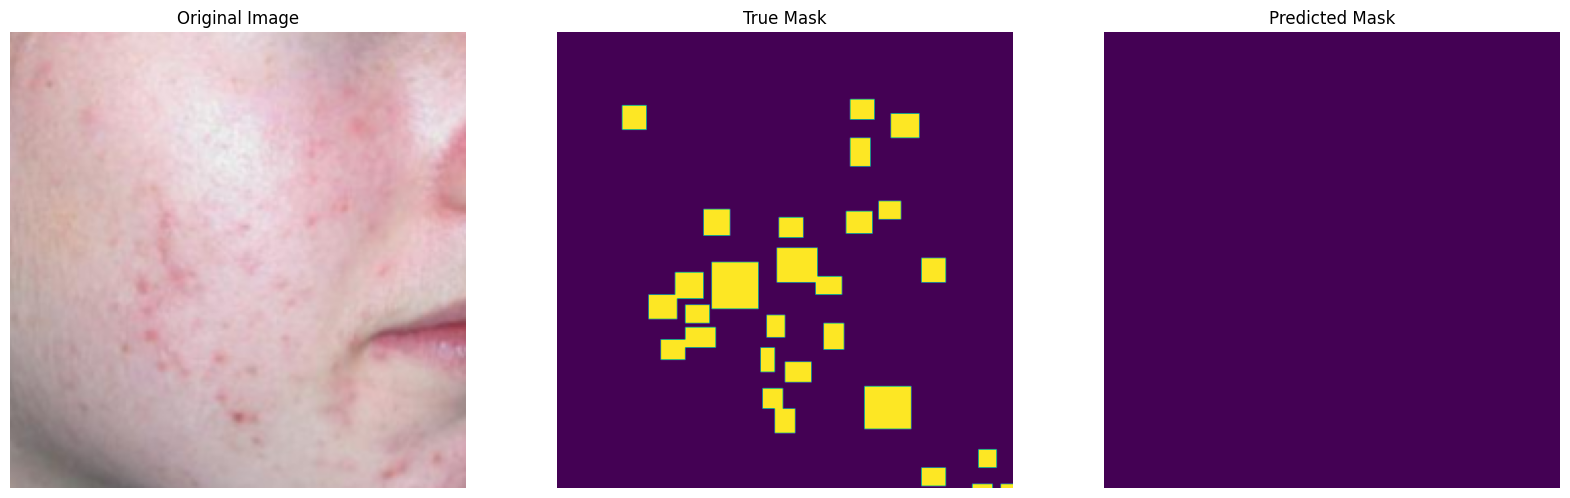

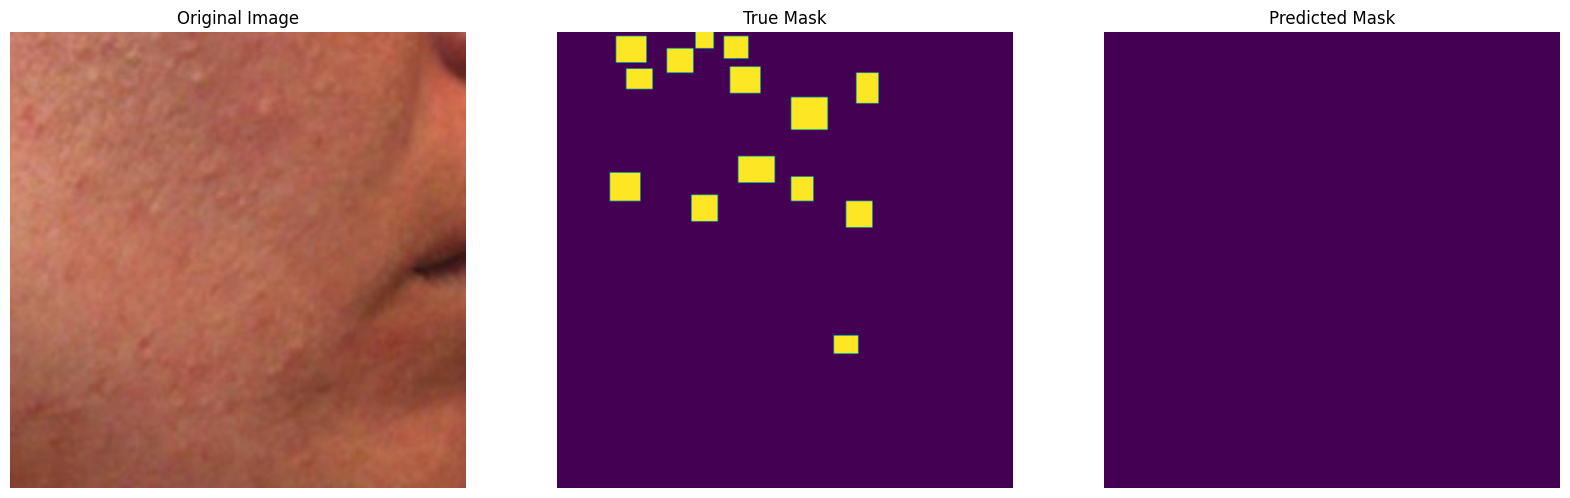

In [12]:
import torch
import matplotlib.pyplot as plt

def visualize_segmentation_results(model, dataloaders, num_images=10):
    model.eval()  # Set the model to evaluation mode
    images_handled = 0

    # Check if GPU is available
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)

    with torch.no_grad():  # No need to track gradients
        for inputs, masks in dataloaders['test']:
            inputs = inputs.to(device).float()  # Ensure inputs are float tensors
            masks = masks.to(device).long()  # Ensure masks are long tensors for comparison

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            # Move images and masks back to CPU for visualization if not on CPU already
            inputs = inputs.cpu()
            masks = masks.cpu()
            preds = preds.cpu()

            for i in range(inputs.size()[0]):
                images_handled += 1
                plt.figure(figsize=(20, 10))

                # Display original image
                ax = plt.subplot(1, 3, 1)
                ax.set_title('Original Image')
                plt.imshow(inputs[i].permute(1, 2, 0).numpy())
                plt.axis('off')

                # Display true mask
                ax = plt.subplot(1, 3, 2)
                ax.set_title('True Mask')
                plt.imshow(masks[i].squeeze().numpy())
                plt.axis('off')

                # Display predicted mask
                ax = plt.subplot(1, 3, 3)
                ax.set_title('Predicted Mask')
                plt.imshow(preds[i].squeeze().numpy())
                plt.axis('off')

                plt.show()

                if images_handled == num_images:
                    return  # Stop after displaying the desired number of images

# Assuming 'dataloaders' is a dictionary with 'test' dataloader defined
# Assuming 'model' is the trained segmentation model loaded with the trained weights

# Call the function
visualize_segmentation_results(model, dataloaders, num_images=10)
